In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np

Height of the object image: 56
Width of the object image:  44


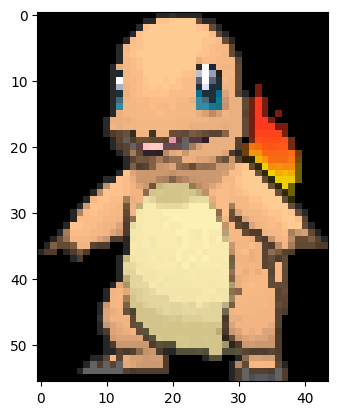

In [4]:
# path = '/home/notomo/Documents/VSC/Models/ObjectLocalization/charmander-tight.png'
path = '/content/charmander-tight.png'
ch = image.load_img(path)
ch = ch.convert("RGB")
POKE_DIM = 200
ch = np.array(ch)
plt.imshow(ch)
CH_H, CH_W, CH_C = ch.shape

print(f'Height of the object image: {CH_H}')
print(f'Width of the object image:  {CH_W}')

In [5]:
def make_model():
    vgg = VGG16(input_shape= [POKE_DIM, POKE_DIM, 3],
                include_top=False,
                weights='imagenet')

    x = Flatten()(vgg.output)
    x = Dense(units=4, activation='sigmoid')(x) # 4 neurons corresponding to: x_topleft, y_topleft, height, width
    model = Model(vgg.input, x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001))

    return model

In [6]:
from skimage.transform import resize

def pokemon_generator_with_resize(batch_size=64):
    while True:
        for _ in range(50): # number of batches in each epoch is just random (I chose 50)
            # Generate X - (batch_size, H, W, 3)
            # Generate y  - (batch_size, 4)
            X = np.zeros(shape=(batch_size, POKE_DIM, POKE_DIM, 3))
            y = np.zeros(shape=(batch_size, 4)) # x_top_right, y_top_right, height, width

            for i in range(batch_size):
                scale = np.random.random() + 0.5
                new_height, new_width = int(CH_H * scale), int(CH_W * scale)
                obj = resize(ch, (new_height, new_width),
                             preserve_range=True).astype(np.uint8)

                x0 = np.random.randint(0, POKE_DIM - new_width)
                y0 = np.random.randint(0, POKE_DIM - new_height)
                x1 = x0 + new_width
                y1 = y0 + new_height

                X[i, y0:y1, x0:x1, :] = obj[:, :, :3]
                y[i, 0] = x0 / POKE_DIM
                y[i, 1] = y0 / POKE_DIM
                y[i, 2] = (y1-y0) / POKE_DIM
                y[i, 3] = (x1-x0) / POKE_DIM

            yield X / 255., y

In [7]:
model = make_model()
model.fit_generator(
    pokemon_generator_with_resize(),
    steps_per_epoch=50,
    epochs=5
)

58889256/58889256 [==============================] - 4s 0us/step


<ipython-input-7-67ade3f1c554>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/5
50/50 [==============================] - 68s 629ms/step - loss: 0.7224
Epoch 2/5
50/50 [==============================] - 32s 634ms/step - loss: 0.5527
Epoch 3/5
50/50 [==============================] - 31s 628ms/step - loss: 0.5482
Epoch 4/5
50/50 [==============================] - 32s 631ms/step - loss: 0.5443
Epoch 5/5
50/50 [==============================] - 31s 630ms/step - loss: 0.5441


1/1 [==============================] - 0s 20ms/step
pred: 86 91 164 148
loss: 0.6607615727931262


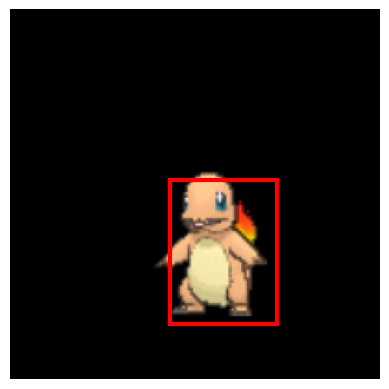

In [26]:
from matplotlib.patches import Rectangle

# Function to make prediction, everytime want to test the model, just run this function
def pokemon_predict():
    X = np.zeros(shape=(POKE_DIM, POKE_DIM, 3))
    y = np.zeros(shape=(4)) # x_top_right, y_top_right, height, width

    scale = np.random.random() + 0.5
    new_height, new_width = int(CH_H * scale), int(CH_W * scale)
    obj = resize(ch,
                 (new_height, new_width),
                 preserve_range=True).astype(np.uint8)
    x0 = np.random.randint(0, POKE_DIM - new_width)
    y0 = np.random.randint(0, POKE_DIM - new_height)
    x1 = x0 + new_width
    y1 = y0 + new_height

    X[y0:y1, x0:x1, :] = obj[:,:,:3]
    y[0] = x0 / POKE_DIM
    y[1] = y0 / POKE_DIM
    y[2] = (y1 - y0) / POKE_DIM
    y[3] = (x1 - x0) / POKE_DIM

    X = np.expand_dims(X, axis=0) / 255.
    y = np.expand_dims(y, axis=0)
    prediction = model.predict(X)[0]
    prediction = prediction * POKE_DIM

    row0 = int(prediction[0])
    col0 = int(prediction[1])
    row1 = int(row0 + prediction[2])
    col1 = int(col0 + prediction[3])
    print("pred:", row0, col0, row1, col1)
    print("loss:", -np.mean(y * np.log(prediction / POKE_DIM) + (1 - y)*np.log(1-prediction / POKE_DIM)))

    rect = Rectangle((prediction[0], prediction[1]),
                     height=prediction[2], width=prediction[3],
                     edgecolor='r',
                     linewidth=3,
                     facecolor='none')
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(X[0])
    ax.add_patch(rect)

    plt.show()


# Run function
pokemon_predict()